In [1]:
# Install libraries
%%capture
!pip install tensorflow-probability
!pip install imageio

In [2]:
# Import General Utilities
import numpy as np
import os
import random
from tqdm.notebook import tqdm, trange
import time
import datetime

#Import tensorflow and its requirements
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.datasets as tfds
from tensorflow.data.experimental import cardinality as dlen
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
AUTOTUNE = tf.data.AUTOTUNE

# Import plotting tools and image converters
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import imageio
from IPython import display

# Import file path variable handling
from pathlib import Path
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

# Constants
batch_size = 20
buffer_size = 64
epochs = 300
img_height = 256
img_width = 256
num_examples_to_generate = 8

print(tf.__version__)

2.7.0-dev20210803


In [3]:
# Download OASIS Dataset from the provided link

def download_and_unzip(url, extract_to='.'): # Credit to Antoine Hebert
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)
    http_response.close()

root_dir = '/root/.keras/datasets'
data_dir = Path(root_dir) / 'keras_png_slices_data'

if len(os.listdir(data_dir)) != 6:
    _URL = "https://cloudstor.aarnet.edu.au/plus/s/tByzSZzvvVh0hZA/download"
    download_and_unzip(_URL, extract_to=root_dir)
    #data_dir = tf.keras.utils.get_file('oasis3', origin=_URL, cache_subdir=root_dir, extract=True)

print(f"Data Directory is {data_dir}")
print(f"Contents: \n\r {os.listdir(data_dir)}")

# Folder Directory Paths
train_dir = data_dir / 'keras_png_slices_train'
train_ans_dir = data_dir / 'keras_png_slices_seg_train'
test_dir = data_dir / 'keras_png_slices_test'
test_ans_dir = data_dir / 'keras_png_slices_seg_test'
val_dir = data_dir / 'keras_png_slices_validate'
val_ans_dir = data_dir / 'keras_png_slices_seg_validate'

Data Directory is \root\.keras\datasets\keras_png_slices_data
Contents: 
 ['keras_png_slices_seg_test', 'keras_png_slices_seg_train', 'keras_png_slices_seg_validate', 'keras_png_slices_test', 'keras_png_slices_train', 'keras_png_slices_validate']


In [4]:
#def count_files(dat_path):
    #return len(list(dat_path.glob('*.*')))

train_ds_list = tf.data.Dataset.list_files(str(train_dir/'*.*'), shuffle=True)
test_ds_list = tf.data.Dataset.list_files(str(test_dir/'*.*'), shuffle=True)
val_ds_list = tf.data.Dataset.list_files(str(val_dir/'*.*'), shuffle=False)

train_ds = train_ds_list.take(dlen(train_ds_list))
test_ds = test_ds_list.take(dlen(test_ds_list))
val_ds = val_ds_list.take(dlen(val_ds_list))

print(f"Train Set is {dlen(train_ds_list)} images, Test Set is {dlen(test_ds_list)} images and Validation Set is {dlen(val_ds_list)} images.")

Train Set is 9664 images, Test Set is 544 images and Validation Set is 1120 images.


In [5]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=1)
    tfimg = tf.image.resize(img, [img_height, img_width])
    tfimg = (tfimg / 255.0) - 0.5 # Normalise data
    # Resize the image to the desired size
    return tfimg

def process_path(file_path):
    #label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [6]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
test_ds = configure_for_performance(test_ds)
val_ds = configure_for_performance(val_ds)

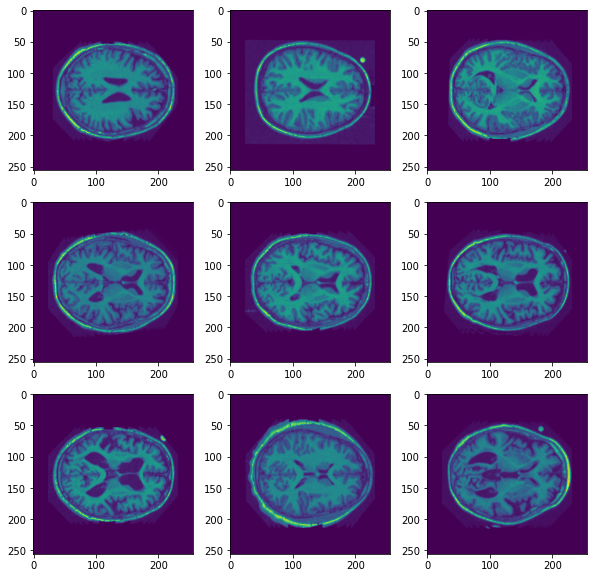

In [7]:
# Show the first scan of 9 patients in the training set
image_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i][:, :, 0])

plt.show()

In [8]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta  # This parameter is best kept between [0.25, 2] as per the paper.

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


class SkipConn(layers.Layer):
    def __init__(self, in_channels, channels, **kwargs):
        super().__init__(**kwargs)

        self.conv1 = layers.Conv2D(channels, 3, activation="relu", padding="same")
        self.conv2 = layers.Conv2D(in_channels, 1, activation="relu", padding="same")

    def call(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        out = x + input
        return out


def get_encoder(input_shape, channels=128, strides=4, name='encoder'):
    encoder_inputs = Input(shape=input_shape, name=name+'input')

    if strides == 4:
        x = layers.Conv2D(channels // 2, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(channels, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2D(channels, 3, activation="relu", padding="same")(x)

    elif strides == 2:
        x = layers.Conv2D(channels // 2, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(channels, 3, activation="relu", padding="same")(x)

    for i in range(2):
        x = SkipConn(channels, 32)(x)
        
    #encoder_outputs = layers.Conv2D(out_channels, 1, padding="same")(x)
    return Model(inputs=encoder_inputs, outputs=x, name="encoder")


def get_decoder(input_shape, out_channels=128, channels=128, strides=4, name='decoder'):
    latent_inputs = Input(shape=input_shape, name=name+'decoder_input')

    x = layers.Conv2D(channels, 3, activation="relu", padding="same")(latent_inputs)

    for i in range(2):
        x = SkipConn(channels, 32)(x)

    if strides == 4:
        #x = layers.Conv2DTranspose(channels, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(channels // 2, 3, activation="relu", strides=2, padding="same")(x)

    #elif strides == 2:
        #x = layers.Conv2DTranspose(channels // 2, 3, activation="relu", strides=2, padding="same")(x)

    decoder_outputs = layers.Conv2DTranspose(out_channels, 3, strides=2, padding="same")(x)
    return Model(inputs=latent_inputs, outputs=decoder_outputs, name="decoder")



In [9]:
class VQVAE(Model):
    def __init__(self, latent_dim=16, num_embeddings=128, embed_dim=64, n_embed=512):
        super(VQVAE, self).__init__()

        #self.encoder = get_encoder(input_shape=(256, 256, 1), channels=num_embeddings, strides=4)
        self.enc_b = get_encoder(input_shape=(256, 256, 1), channels=num_embeddings, strides=4)
        self.enc_t = get_encoder(input_shape=(64, 64, num_embeddings), channels=num_embeddings, strides=2)
        #self.quantize_conv_t = layers.Conv2D(embed_dim, 1, activation="relu", padding="same")
        self.quantize_t = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer_t")

        self.dec_t = get_decoder(input_shape=(32, 32, num_embeddings), out_channels=num_embeddings, channels=num_embeddings, strides=2)
        self.quantize_b = VectorQuantizer(n_embed, embed_dim, name="vector_quantizer_b")
        self.upsample_t = layers.Conv2DTranspose(embed_dim, 3, activation="relu", strides=2, padding="same")

        self.dec = get_decoder(input_shape=(64, 64, 2 * num_embeddings + embed_dim), out_channels=1, channels=num_embeddings, strides=4)
        #self.decoder = get_decoder(input_shape=(64, 64, num_embeddings), channels=num_embeddings, strides=2)
        #self.vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
        #self.dec_t = get_decoder(channels=num_embeddings)

    def encode(self, input):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)

        #quant_t = self.quantize_conv_t(enc_t)
        #quant_t = layers.Permute((1, 3, 4, 2), input_shape=quant_t.shape)(quant_t)
        quant_t = self.quantize_t(enc_t)
        #quant_t = layers.Permute((1, 4, 2, 3))(quant_t)

        dec_t = self.dec_t(quant_t)
        enc_b = tf.concat([dec_t, enc_b], 3)

        #quant_b = self.quantize_conv_b(enc_b)
        #quant_b = layers.Permute((1, 3, 4, 2))(quant_b)
        quant_b = self.quantize_b(enc_b)
        #quant_b = layers.Permute((1, 4, 2, 3))(quant_b)
        
        return quant_t, quant_b

    def decode(self, quant_t, quant_b):
        upsample_t = self.upsample_t(quant_t)
        quant = tf.concat([upsample_t, quant_b], 3)
        dec = self.dec(quant)

        return dec

    def call(self, input):
        #encoder_outputs = self.encoder(inputs)
        #quantized_latents = self.vq_layer(encoder_outputs)
        #reconstructions = self.decoder(quantized_latents)
        #return reconstructions
        quant_t, quant_b = self.encode(input)
        dec = self.decode(quant_t, quant_b)

        return dec

def get_vqvae(latent_dim=16, num_embeddings=128):
    inputs = Input(shape=(256, 256, 1))
    encoder_outputs = self.encoder(inputs)
    quantized_latents = self.vq_layer(encoder_outputs)
    reconstructions = self.decoder(quantized_latents)
    return Model(inputs, reconstructions, name="vq_vae")

vqvae_structure = VQVAE()
#vqvae_structure.summary()
#get_vqvae().summary()

In [10]:
class VQVAETrainer(tf.keras.models.Model):
    def __init__(self, model, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = model #get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = tf.keras.metrics.Mean(name="vq_loss")
        self.ssim = tf.keras.metrics.Mean(name="ssim")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
            self.ssim,
        ]

    @tf.function
    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

            ssim_score = tf.image.ssim(x + 0.5, reconstructions + 0.5, max_val=1.0, filter_size=255)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))
        self.ssim.update_state(ssim_score)

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
            "ssim": self.ssim.result(),
        }

In [11]:
def generate_and_save_images(model, epoch, test_sample, save_dir):
    encoded_t, encoded_b = model.encode(test_sample)
    predictions = model.decode(encoded_t, encoded_b)
    fig = plt.figure(figsize=(4 * num_examples_to_generate, 8))

    for i in range(num_examples_to_generate):

        # display original + noise
        ax = plt.subplot(2, num_examples_to_generate, i + 1)
        plt.title("Original")
        plt.imshow(test_sample[i][:, :, 0])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        bx = plt.subplot(2, num_examples_to_generate, i + num_examples_to_generate + 1)
        plt.title("Reconstruction")
        plt.imshow(predictions[i][:, :, 0])
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig(save_dir / f'image_at_epoch_{epoch:04}.png')

    plt.show()

# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in val_ds.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

save_path = Path('/root/image_sets')
if not os.path.exists(save_path):
    os.makedirs(save_path)
files = os.listdir(save_path)
if len(os.listdir(save_path / f'model{max(len(files) - 1, 0):03}')) == 0:
    save_images = save_path / f'model{len(files) - 1:03}'
else:
    save_images = save_path / f'model{len(files):03}'
    os.makedirs(save_images)

Epoch: 300/300
484/484 128s 263ms/step - loss: 3428.949951171875 - reconstruction_loss: 0.08711113035678864 - vqvae_loss: 3428.886962890625 - SSIM: 0.8569458723068237


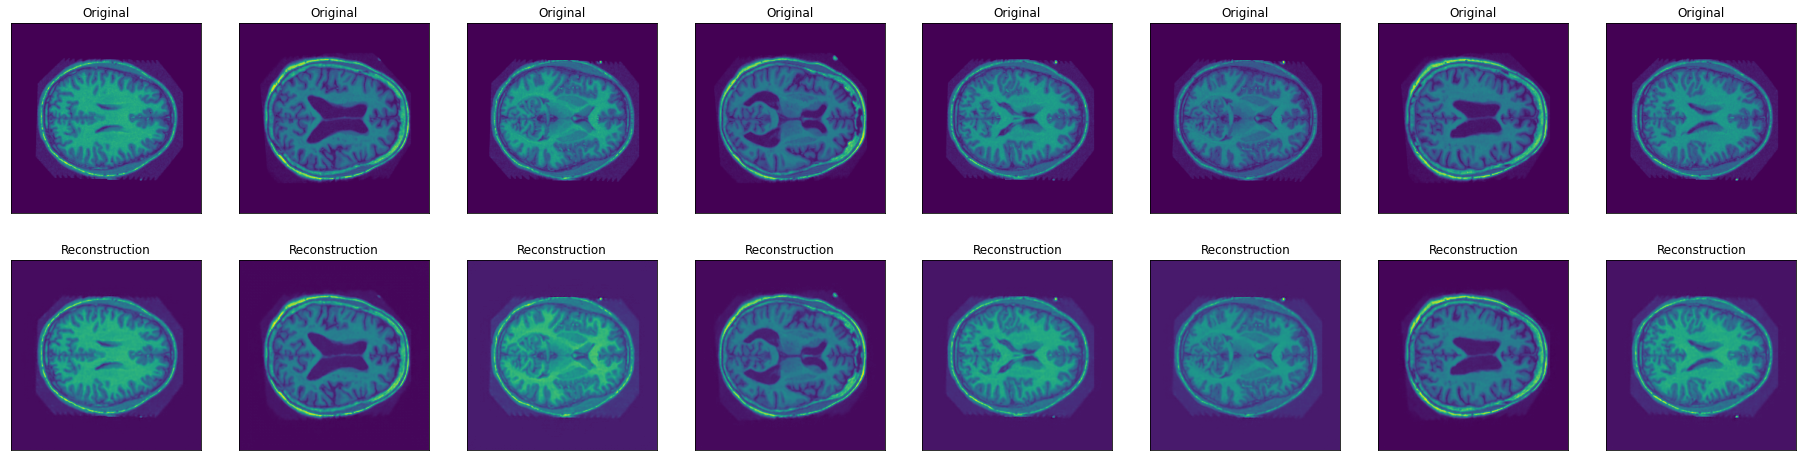

In [12]:
vqvae_trainer = VQVAETrainer(vqvae_structure, 0.015, latent_dim=16, num_embeddings=64)
vqvae_trainer.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
#vqvae_trainer.fit(train_ds, epochs=5, batch_size=batch_size)

generate_and_save_images(vqvae_structure, 0, test_sample, save_images)
loss_lists = []

for epoch in range(1, epochs + 1):
    start_time = time.time()
    step_time = 0
    iters = 0
    for train_x in tqdm(train_ds, desc=f"Epoch {epoch}/{epochs} - Model Step"):
        step_start = time.time()
        losses = vqvae_trainer.train_step(train_x)
        step_time = step_time + time.time() - step_start
        iters = iters + 1
    end_time = time.time()
    step_time = step_time / iters

    #loss = tf.keras.metrics.Mean()
    #for val_x in val_ds:
        #loss(compute_loss(vqvae_trainer, val_x))
    display.clear_output(wait=False)
    print(f"Epoch: {epoch}/{epochs}\n{iters}/{iters} {round(end_time - start_time)}s {round(step_time * 1000)}ms/step - loss: {losses['loss']} - reconstruction_loss: {losses['reconstruction_loss']} - vqvae_loss: {losses['vqvae_loss']} - SSIM: {losses['ssim']}")
    generate_and_save_images(vqvae_structure, epoch, test_sample, save_images)
    loss_lists.append([losses['loss'], losses['reconstruction_loss'], losses['vqvae_loss'], losses['ssim']])


INFO:tensorflow:Assets written to: /root/trained_model/model007\assets


INFO:tensorflow:Assets written to: /root/trained_model/model007\assets


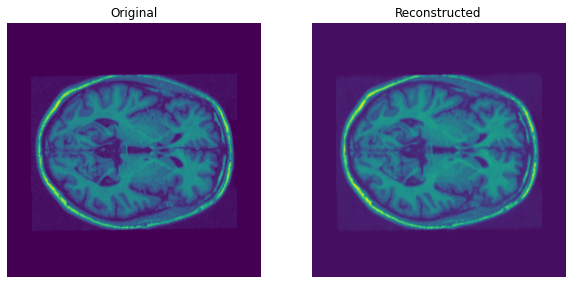

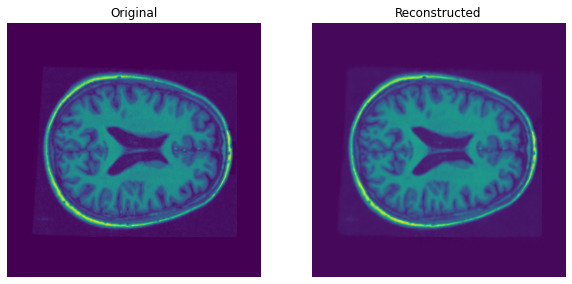

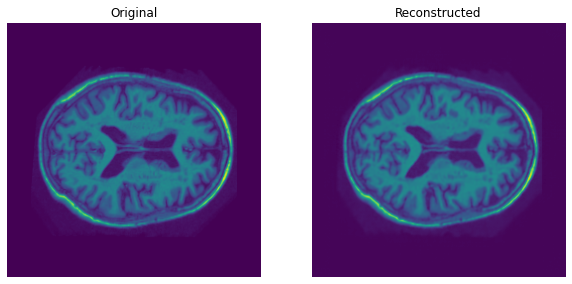

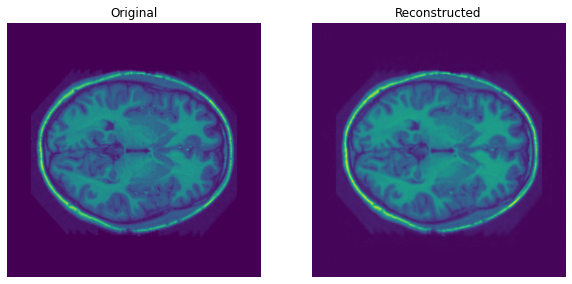

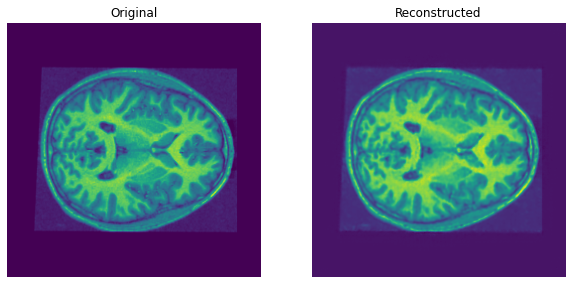

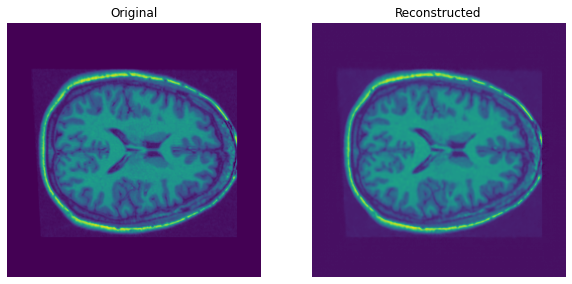

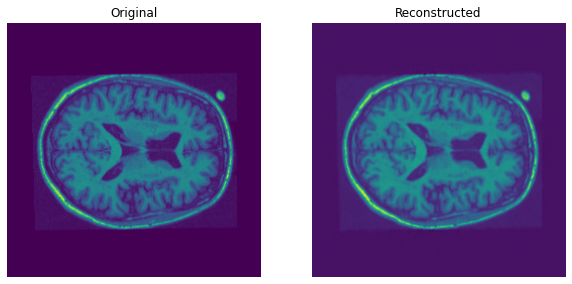

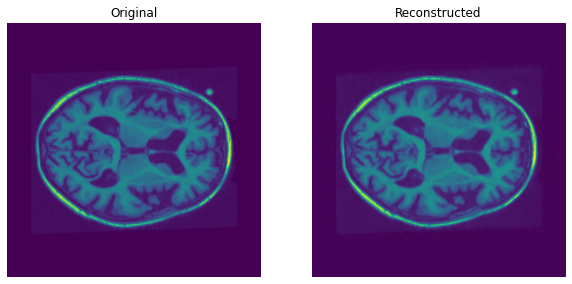

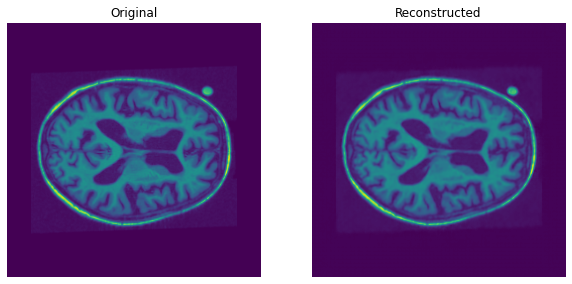

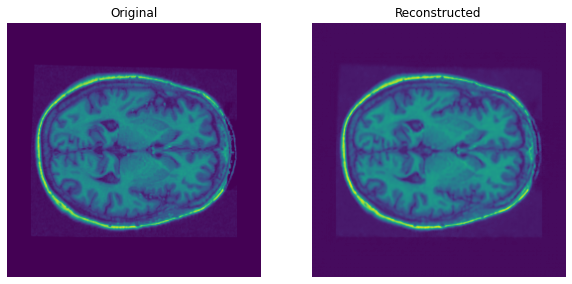

In [13]:
def show_subplot(original, reconstructed):

    original = original + 0.5
    reconstructed = reconstructed + 0.5

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(original[:, :, 0])
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed[:, :, 0])
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
files = os.listdir(Path('/root/trained_model'))
trained_vqvae_model.save(f'/root/trained_model/model{len(files):03}')
test_images = next(iter(test_ds))
reconstructions_test = trained_vqvae_model.predict(test_images)

for i in range(10):
    show_subplot(test_images[i], reconstructions_test[i])


Low filter encoder is (20, 32, 32, 128), High filter encoder is (20, 64, 64, 256)


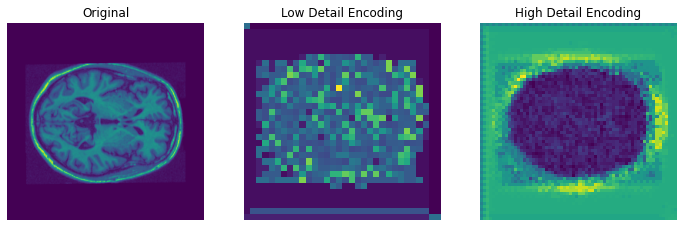

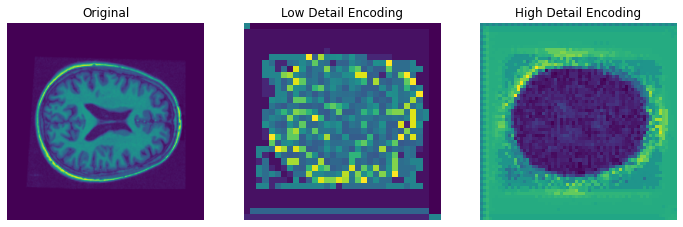

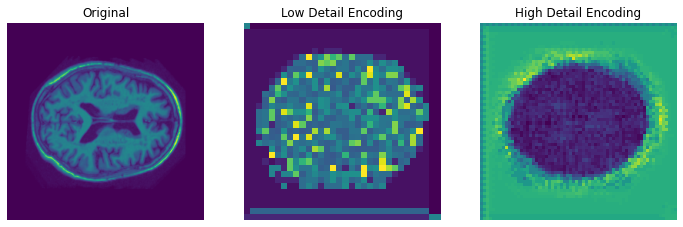

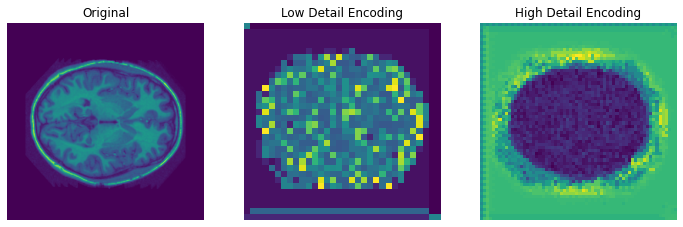

In [14]:
# Testing encoding visualisation
enc_out_t, enc_out_b = trained_vqvae_model.encode(test_images)
print(f"Low filter encoder is {enc_out_t.shape}, High filter encoder is {enc_out_b.shape}")

for i in range(4):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i][:, :, 0] + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(enc_out_t[i][:, :, 22] + 0.5) # 64 Filters
    plt.title("Low Detail Encoding")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(enc_out_b[i][:, :, 100] + 0.5) # 256 Filters
    plt.title("High Detail Encoding")
    plt.axis("off")
    plt.show()

# One hot encode the vector spaces to collapse them down.


In [15]:
ssim_total = 0

for batch in tqdm(test_ds):
    comparisons = batch
    reconstructed_comp = trained_vqvae_model.predict(batch)

    for i in range(batch.shape[0]):
        ssim = tf.image.ssim(comparisons[i] + 0.5, reconstructed_comp[i] + 0.5, max_val=1.0)
        ssim_total += ssim

print(f"Average SSIM score is {ssim_total / float(dlen(test_ds_list))}.")

  0%|          | 0/28 [00:00<?, ?it/s]

Average SSIM score is 0.9741209745407104.


In [21]:
# PixelCNN implementation
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])


pixelcnn_inputs = Input(shape=(32, 32), dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=32, activation="relu", padding="same"
)(ohe)

for _ in range(2):
    x = ResidualBlock(filters=128)(x)

for _ in range(2):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()

Model: "pixel_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32)]          0         
_________________________________________________________________
tf.one_hot_2 (TFOpLambda)    (None, 32, 32, 64)        0         
_________________________________________________________________
pixel_conv_layer_12 (PixelC  (None, 32, 32, 128)       8388736   
onvLayer)                                                        
_________________________________________________________________
residual_block_4 (ResidualB  (None, 32, 32, 128)       98624     
lock)                                                            
_________________________________________________________________
residual_block_5 (ResidualB  (None, 32, 32, 128)       98624     
lock)                                                            
_________________________________________________________

In [17]:
vqvae_structure.summary()

Model: "vqvae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Functional)         (None, 64, 64, 128)       304320    
_________________________________________________________________
encoder (Functional)         (None, 32, 32, 128)       229888    
_________________________________________________________________
vector_quantizer_t (VectorQ  multiple                  2048      
uantizer)                                                        
_________________________________________________________________
decoder (Functional)         (None, 64, 64, 128)       377408    
_________________________________________________________________
vector_quantizer_b (VectorQ  multiple                  32768     
uantizer)                                                        
_________________________________________________________________
conv2d_transpose_1 (Conv2DT  multiple                  73792 